In [6]:
import mdtraj as md
import numpy as np
import pandas as pd 

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

import deeptime as dt
from pyemma.coordinates import tica
import pyemma as pe

from funcs_validate_msm import *
from funcs_sample import *
from funcs_featurise import * 
from funcs_characterise import *
from paths import *
from natsort import natsorted

### Load pre-processed initial structures

In [3]:
crystal_files = Path("./human_egfr/").rglob("kinoml*.pdb")
crystal_files = natsorted([str(f) for f in crystal_files])

In [4]:
frames = [] 
for crystal in crystal_files:
    sample_frame = md.load(crystal)
    sample_frame = sample_frame.atom_slice(sample_frame.top.select('mass>1.1'))
    frames.append(sample_frame)
crystals = md.join(frames)
crystals = crystals.superpose(crystals, 0)

### Project onto feature space 

In [14]:
dbdist_f = dbdist_featuriser(crystals)
ploop_f = ploop_featuriser(crystals)
achelix_f = achelix_featuriser(crystals)
rspine_f = rspine_featuriser(crystals)

In [75]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

def hierarchical_clustering(ftraj, stride=1, method='average', maxclust=3):
    Z = linkage(ftraj[::stride], method=method)
    R = dendrogram(Z)
    cluster_labels = fcluster(Z, maxclust, criterion='maxclust')

    points = []
    for i in range(maxclust):
        points.append(ftraj[::stride][cluster_labels == i+1])
    return cluster_labels, points

[8, 56, 336]


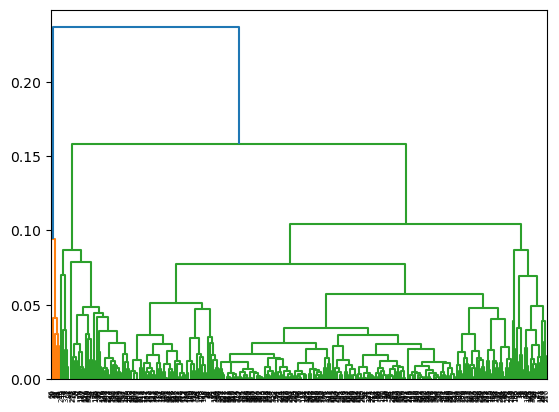

In [80]:
cluster_labels, points = hierarchical_clustering(ploop_f, stride=1, method='average', maxclust=3)
print([len(p) for p in points])

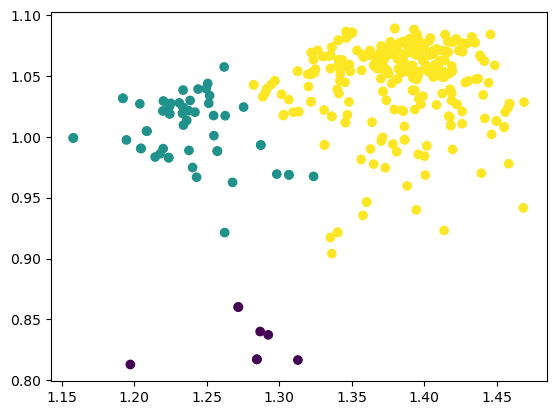

In [81]:
plt.scatter(ploop_f[:,0], ploop_f[:,1], c=cluster_labels)

In [82]:
for s in np.arange(len(points))+1:
    indices = np.where(cluster_labels == s)[0]
    samples = np.random.choice(a=indices, size=5)
    crystals[samples].save_pdb(f"data_egfr/crystal_samples/ploop_samples_{s}.pdb")

### Project crystal structures on to the tICA space

Use unbootstrapped tICA, kmeans, and transition matrix

In [26]:
study_name = 'n_clusters'
hp_id = 1
savedir = Path(f'data_egfr/msm/validation/{study_name}_hp{hp_id}_validate')

In [44]:
featurisers = [dbdist_featuriser, dbdihed_featuriser, aloop_featuriser, ploopdihed_featuriser, achelix_featuriser]

ftrajs = []
for f in featurisers:
    ftraj = f(crystals, save_to_disk=None)
    if 'dihed' in f.__name__:
        ftraj = np.concatenate([np.cos(ftraj), np.sin(ftraj)], axis=1)    
    ftrajs.append(ftraj)
ftraj_cat = np.concatenate(ftrajs, axis=1)
ftraj_cat.shape

(400, 284)

In [47]:
tica_mod = tica()
tica_mod.load(savedir/'tica_mod')
tica_mod.mean = np.load(savedir/'tica_mean.npy')
tica_mod.cov = np.load(savedir/'tica_cov.npy')
tica_mod.cov_tau = np.load(savedir/'tica_cov_tau.npy')

/home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)


In [50]:
ttraj = tica_mod.transform(ftraj_cat)
ttraj.shape

(400, 181)